# simple 6D PS reconstruction

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan_2screens
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data_2screens
from phase_space_reconstruction.utils import split_2screen_dset
from phase_space_reconstruction.train import train_3d_scan_2screens

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

from stats import plot_projections_with_contours

## Load data

In [2]:
# load data
data_dir = '/global/cfs/cdirs/m669/rroussel/AWA_DATA/12-07_6D-PSR/reconstruction_scan'
save_dir =  'results'
dset = torch.load(os.path.join(data_dir, 'dset_3d_12_07_full_scan.pt'))
train_dset, test_dset = split_2screen_dset(dset)

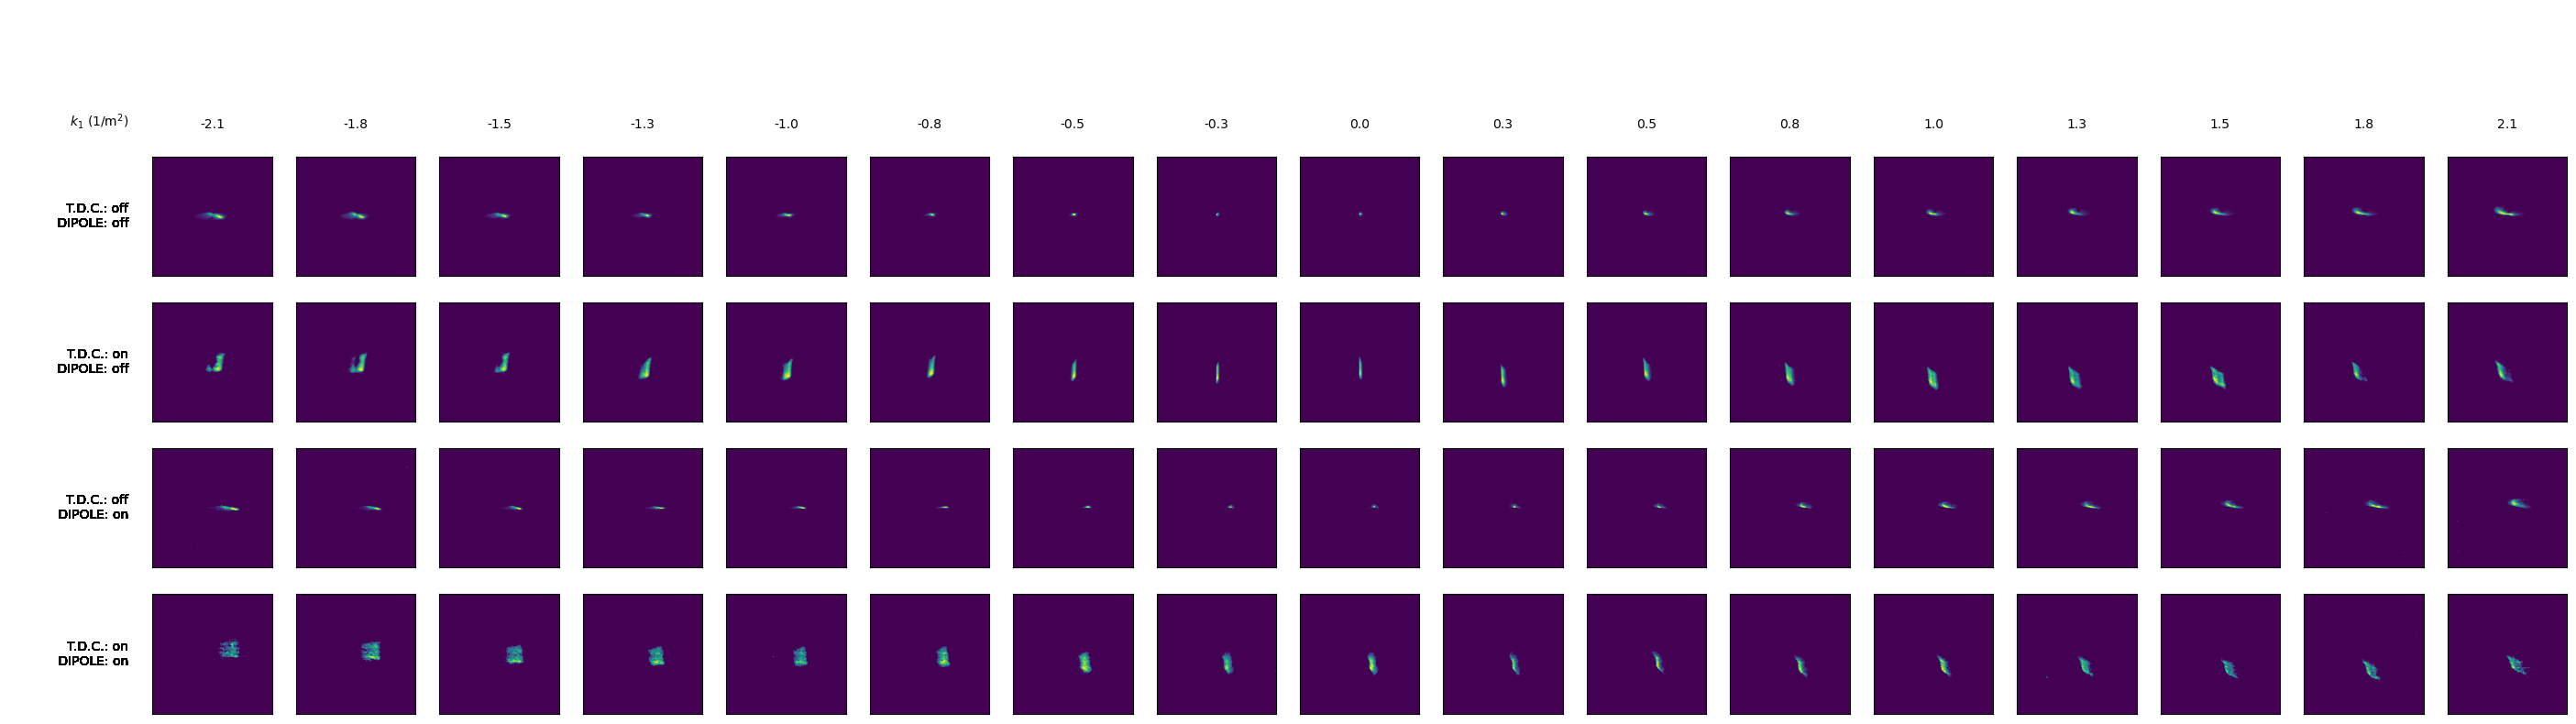

In [3]:
plot_3d_scan_data_2screens(dset)
plt.show()

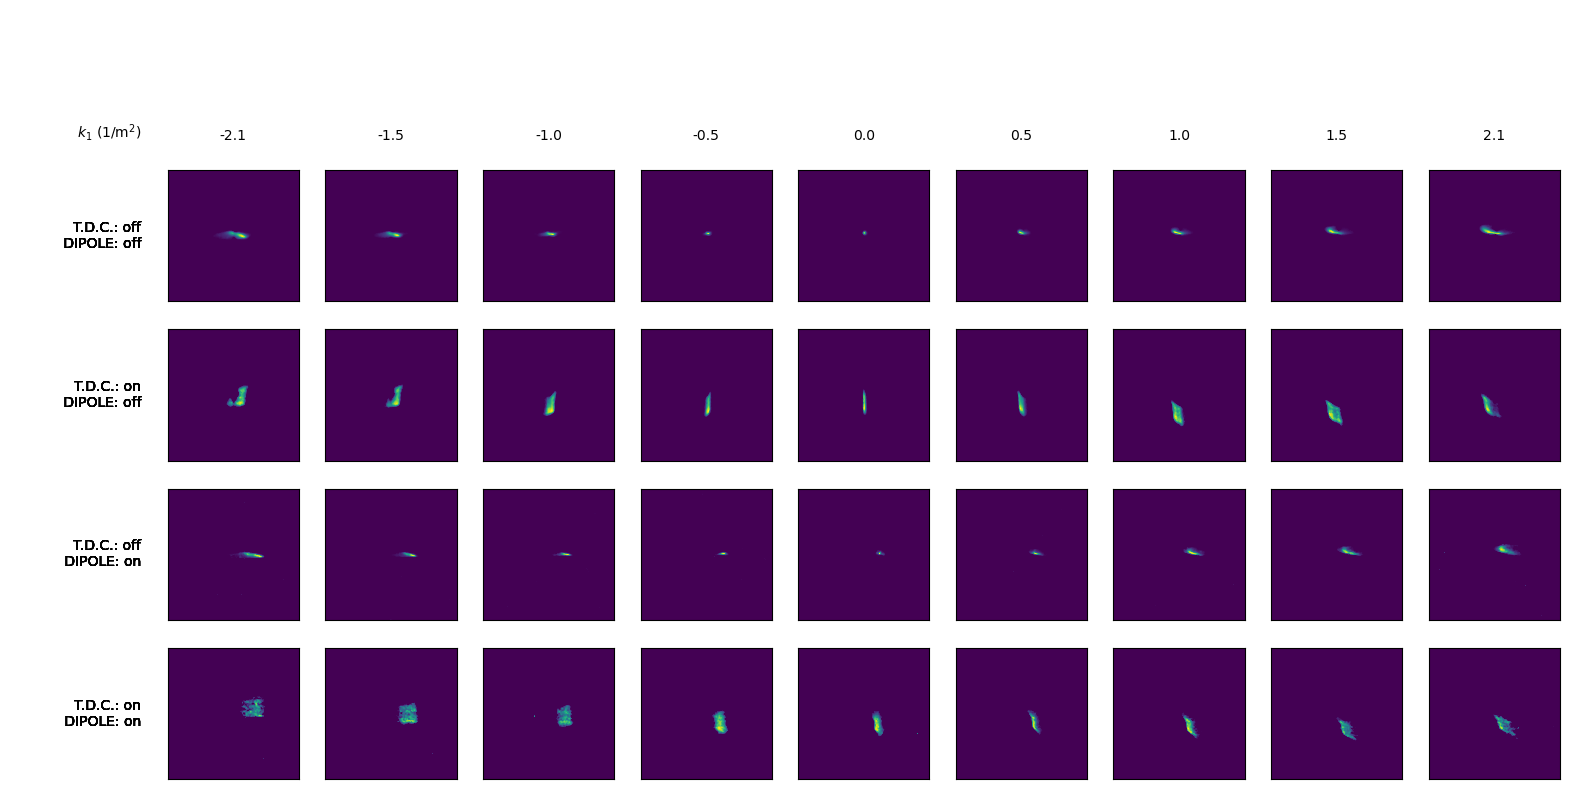

In [4]:
plot_3d_scan_data_2screens(train_dset)
plt.show()

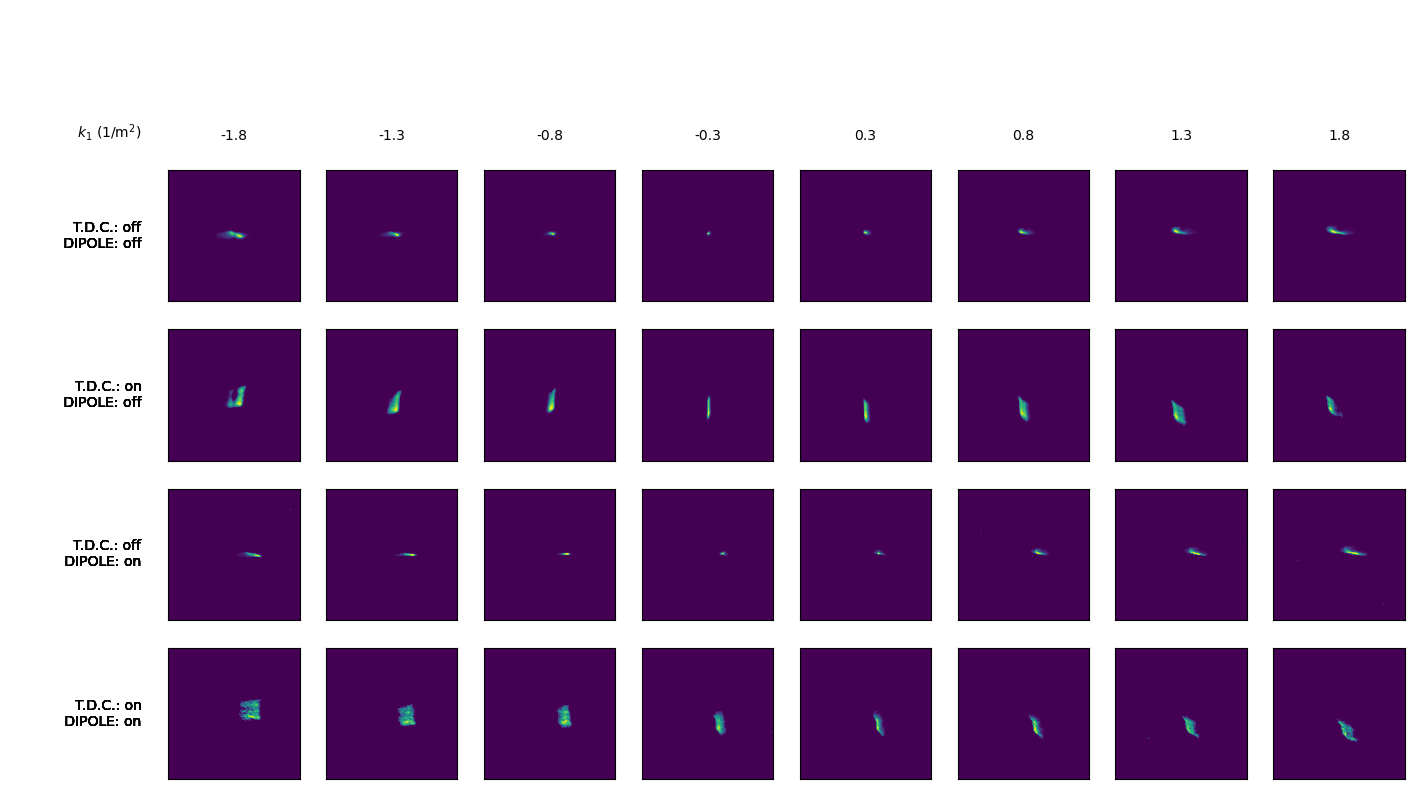

In [5]:
plot_3d_scan_data_2screens(test_dset)
plt.show()

## Define diagnostics lattice parameters

In [6]:
# diagnostic beamline:
p0c = 62.0e6
lattice0 = quad_tdc_bend(p0c=p0c, dipole_on=False)
lattice1 = quad_tdc_bend(p0c=p0c, dipole_on=True)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [0, 2, 4] 

# create 2 diagnostic screens: 
def create_screen(size, pixels):
    bins = torch.linspace(-size/2, size/2, pixels)
    bandwidth = (bins[1]-bins[0]) / 2
    return ImageDiagnostic(bins, bins, bandwidth)

screen0 = create_screen(30.22*1e-3, 700)
screen1 = create_screen(26.96*1e-3, 700)

### 10,000 particles

In [7]:
%%time

# training
pred_beam = train_3d_scan_2screens(
    train_dset, 
    lattice0,
    lattice1, 
    p0c, 
    screen0,
    screen1,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000, 
    device = 'cuda'
    )
pred_beam = pred_beam.numpy_particles()
torch.cuda.empty_cache()

Using device: cuda


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(341077.4271, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
100 tensor(169480.2060, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
200 tensor(151064.2082, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
300 tensor(162666.9887, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
400 tensor(138876.2703, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
500 tensor(150871.5103, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
600 tensor(158557.0758, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
700 tensor(154669.7576, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
800 tensor(156253.4607, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
900 tensor(176933.0193, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)
CPU times: user 14min 7s, sys: 10min 51s, total: 24min 59s
Wall time: 24

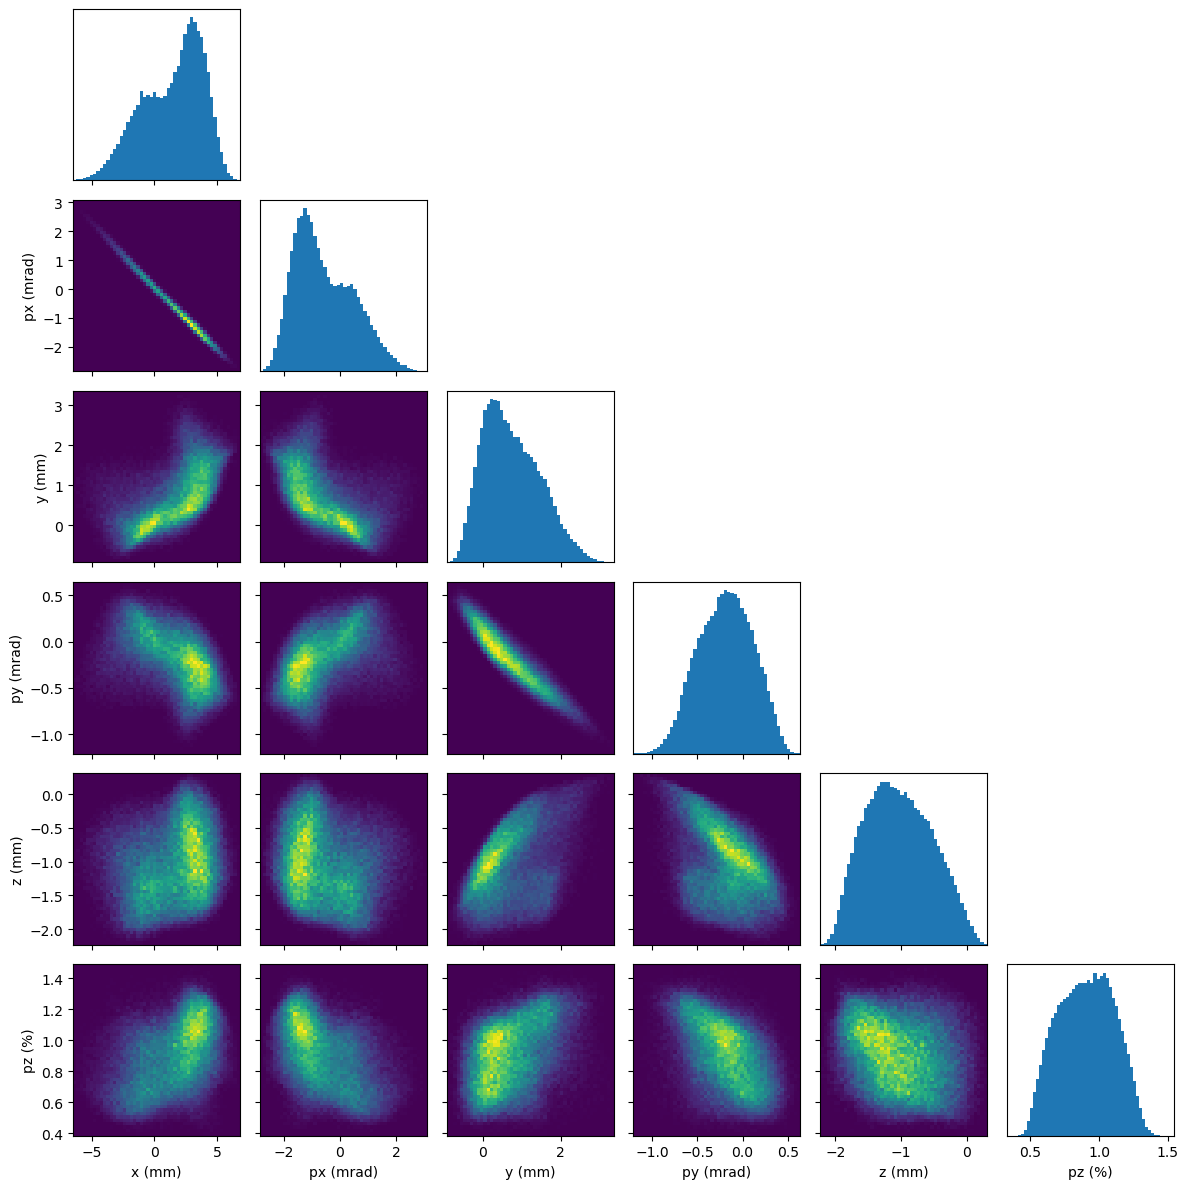

In [8]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam,
                           #custom_lims = lims,
                           bins = 50
                           )
plt.show()

In [9]:
torch.save(pred_beam, 'pred_beam.pt')